# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Importing Libraries & loading datasets:

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
import math
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Additional libraries
import time
from scipy.stats import randint

pd.set_option('display.max_columns', None) # Set display option to show all columns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [2]:
# Save files as csv files
#portfolio.to_csv('portfolio_marc.csv', index=False)
#profile.to_csv('profile_marc.csv', index=False)
#transcript.to_csv('transcript_marc.csv', index=False) 


## 2. Data Accessing
### a) First Look at Portfolio Dataset

In [3]:
def dataset_summary(dataset, dataset_name):
    """
    Function to generate summary information for a dateset including shape, head, data types, description, shape, data types, 
    null value count and percentage of null values.
    
    Parameters:
    - dataset: loaded dataset (=dataframe) for which summary information is dispayed.
    - dataset_name: name of dataset for printout
    
    Returns:
    - Displays information: shape, head, data types, description, shape, data types, null value count and percentage of null values.
    """  
    
      
    # Display the shape of the Dataframe
    print("Dataset:", dataset_name, "\n\nShape: Columns:", dataset.shape[1], " Rows:", dataset.shape[0],"\n")
    
    # Display the first few rows
    print("Head:\n",dataset.head(10),"\n")
        
    # Display data types of columns
    print("Data types:\n", dataset.dtypes, "\n")
        
    # Display summary statistics
    print("Description:\n", dataset.describe(), "\n")

    # Check for null values and display the count them for each colunm
    null_value_counts = dataset.isnull().sum()
    print("Null value counts:\n", null_value_counts)

    # Calculate percentage of null values for each column
    total_rows = len(dataset)
    null_percentage = (null_value_counts / total_rows) * 100
    print("\nPercentage of null values:\n", null_percentage)


In [4]:
dataset_summary(portfolio, 'portfolio')


Dataset: portfolio 

Shape: Columns: 6  Rows: 10 

Head:
    reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb

In [5]:
# Print unique offer types in column 'offer_type' 
unique_values = portfolio['offer_type'].unique()
print("Unique values in column 'offer_type':", unique_values)


Unique values in column 'offer_type': ['bogo' 'informational' 'discount']


### b)  First Look at Profile Dataset

In [6]:
dataset_summary(profile, 'profile')


Dataset: profile 

Shape: Columns: 5  Rows: 17000 

Head:
   gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN
5      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002       NaN
8      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
9   None  118  8974fc5686fe429db53ddde067b88302          20161122       NaN 

Data types:
 gender               object
age                   int64
id                   object
became

In [7]:
# Checking for duplicate member. => There are no duplicates!
profile.duplicated().sum()


0

In [8]:
# Analyzing for unique values 
# => income with NaN! 
# => High number with Age of 118! Probably maximum value in the app; can be interpreted as a zero value.

# unique values in column 'offer_type' 
unique_values = profile['gender'].unique()
print("Unique values in column 'gender':\n", unique_values,"\n")

# unique values in column 'age' 
unique_values = profile['age'].unique()
unique_values_sorted = sorted(unique_values, reverse=False) 
print("Unique values in column 'age':\n", unique_values_sorted,"\n")


# unique values in column 'income' 
unique_values = profile['income'].unique()
unique_values_sorted = sorted(unique_values, reverse=False) 
print("Unique values in column 'income':\n", unique_values_sorted,"\n")


Unique values in column 'gender':
 [None 'F' 'M' 'O'] 

Unique values in column 'age':
 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 118] 

Unique values in column 'income':
 [nan, 30000.0, 31000.0, 32000.0, 33000.0, 34000.0, 35000.0, 36000.0, 37000.0, 38000.0, 39000.0, 40000.0, 41000.0, 42000.0, 43000.0, 44000.0, 45000.0, 46000.0, 47000.0, 48000.0, 49000.0, 50000.0, 51000.0, 52000.0, 53000.0, 54000.0, 55000.0, 56000.0, 57000.0, 58000.0, 59000.0, 60000.0, 61000.0, 62000.0, 63000.0, 64000.0, 65000.0, 66000.0, 67000.0, 68000.0, 69000.0, 70000.0, 71000.0, 72000.0, 73000.0, 74000.0, 75000.0, 76000.0, 77000.0, 78000.0, 79000.0, 80000.0, 81000.0, 82000.0, 83000.0, 84000.0, 85000.0, 86000.0, 87000.0, 880

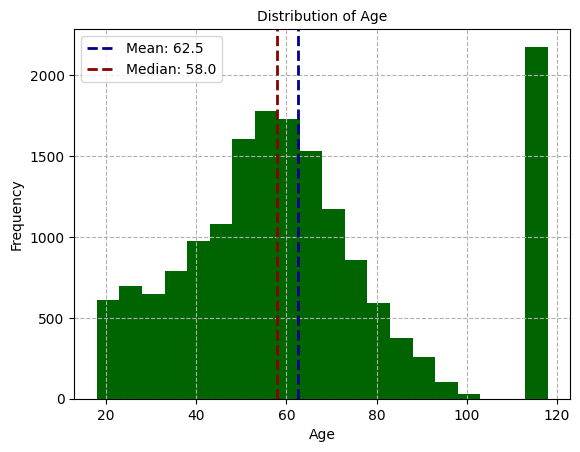

In [9]:
# visual distribution of age, mean age and median age

mean_age = profile['age'].mean()
median_age = profile['age'].median()

plt.hist(profile['age'], bins=20, color='darkgreen')
plt.axvline(mean_age, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.1f}')
plt.title('Distribution of Age', fontsize=10)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(linestyle='--');
plt.legend()
plt.show()


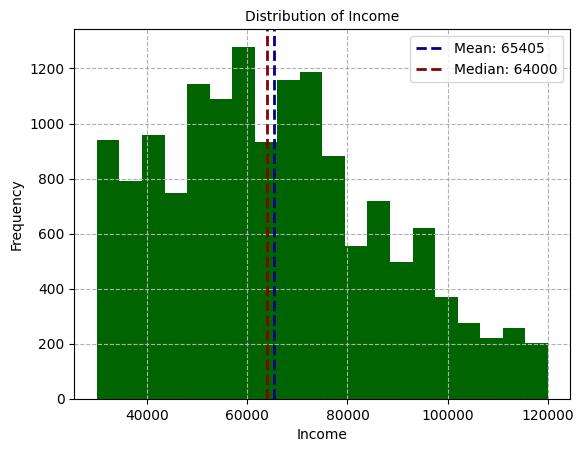

In [10]:
# visual distribution of income, mean income and median income

mean_income = profile['income'].mean()
median_income = profile['income'].median()

plt.hist(profile['income'], bins=20, color='darkgreen')
plt.axvline(mean_income, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_income:.0f}')
plt.axvline(median_income, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_income:.0f}')
plt.title('Distribution of Income', fontsize=10)
plt.xlabel('Income', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(linestyle='--');
plt.legend()
plt.show()


### c) First Look at Transcript Dataset

In [11]:
dataset_summary(transcript, 'transcript')


Dataset: transcript 

Shape: Columns: 4  Rows: 306534 

Head:
                              person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
6  c4863c7985cf408faee930f111475da3  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   
9  31dda685af34476cad5bc968bdb01c53  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940

In [12]:
# Analyzing for unique values
# unique values in column 'event' 
unique_values = transcript['event'].unique()
print("Unique values in column 'event':\n", unique_values,"\n")

unique_values = transcript['time'].unique()
print("Unique values in column 'time':\n", unique_values,"\n")
# Time only shows values in steps of 6 -> it could be 6-hour periods since the beginning 
print("Max values in column 'time':", max(unique_values), "\n")
print("If the unit of 'time' is 'hours', this means that the Starbucks offers ran for a maximum time period of approximately", round(max(unique_values)/24) , "days (= or for" , round(max(unique_values)/24/30), "month). \n")  


Unique values in column 'event':
 ['offer received' 'offer viewed' 'transaction' 'offer completed'] 

Unique values in column 'time':
 [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714] 

Max values in column 'time': 714 

If the unit of 'time' is 'hours', this means that the Starbucks offers ran for a maximum time period of approximately 30 days (= or for 1 month). 



In [13]:
# Dataset Transcript: Extracting values from the 'value' column into separate columns
# The 'value' column contains a dictionary with keys 'amount', 'offer_id', and 'reward'.
# This code extracts these values into individual columns for easier access and analysis.

# Check if the 'value' column exists in the DataFrame
if 'value' not in transcript.columns:
    print("Warning: The column 'value' does not exist in the DataFrame. No changes made.")
else:
    # Extract 'amount' from the 'value' column
    transcript['value_amount'] = transcript['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)

    # Extract 'offer_id' from the 'value' column, checking for both 'offer_id' and 'offer id' keys
    transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') if isinstance(x, dict) else x.get('offer id') if isinstance(x, dict) else None)

    # Extract 'reward' from the 'value' column
    transcript['value_rewards'] = transcript['value'].apply(lambda x: x.get('reward') if isinstance(x, dict) else None)

    # Drop the original 'value' column as it is no longer needed
    transcript.drop(columns=['value'], inplace=True)


In [14]:
# Check for duplicates in the 'transcript' DataFrame
duplicate_count = transcript.duplicated().sum()
print("Duplicates in 'transcript':", duplicate_count)

# Execute the following lines only if duplicates exist
if duplicate_count > 0:
    print("Duplicates were deleted!")
    transcript.drop_duplicates(inplace=True)
    print("Check remaining duplicates:", transcript.duplicated().sum())
else:
    print("No duplicates found. No rows were deleted.")
  

Duplicates in 'transcript': 397
Duplicates were deleted!
Check remaining duplicates: 0


## 3. Data processing and Cleaning
### a) General Functions for Data processing and Cleaning 

In [15]:
def rename_column(dataset, column_name_old, column_name_new):
    """
    Function to rename a column in a DataFrame.
    
    Parameters:
    - dataset: The DataFrame containing the column to be renamed.
    - column_name_old: The current name of the column to be renamed.
    - column_name_new: The new name to assign to the column.
    
    Returns:
    - Updated DataFrame with the column renamed.
    """
    
    # Check if old_name and new_name are strings
    if not isinstance(column_name_old, str) or not isinstance(column_name_new, str):
        raise ValueError("Both column_name_old and column_name_new must be strings.")
    
    # Check if the old_name exists in the DataFrame
    if column_name_old not in dataset.columns:
        print(f"Warning: Column '{column_name_old}' does not exist in the DataFrame. No changes made.")
        return dataset 
    
    # Rename the column
    dataset.rename(columns={column_name_old: column_name_new}, inplace=True)
    
    return dataset


def transfom_column_to_categorial(df, column_name, prefix):
    """
    Converts values in a specified column (containing lists) into new categorial columnsfilled with 0 and 1.
    The original column will be dropped.

    Parameters:
    - df: DataFrame containing the column to be transformed.
    - column_name: Name of the column to be transformed into categorial columns.
    - prefix: A string (e.g. old_column_name') to be prefixed to the new column names.

    Returns:
    - DataFrame: A modified DataFrame with new ategorial columns based on each unique value in the specified column.
                  The original column is dropped.
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Warning: The column '{column_name}' does not exist in the DataFrame. No changes made.")
        return df  # Return the original DataFrame without changes

    # Initialize a set to hold unique values from the specified column's lists
    unique_values = set()
    for row in df[column_name]:
        if isinstance(row, list):  # Ensure the entry is a list
            unique_values.update(row)  # Update the set with unique values

    # Iterate through each unique value and create new binary columns
    for value in unique_values:
        if pd.notna(value):  # Check for non-finite values (like NaN)
            # Define the new column name based on the unique value with the prefix
            new_column_name = f"{prefix}{value}"
            
            # Create a new column filled with 1s where the original column lists contain the unique value, 0s otherwise
            df[new_column_name] = df.apply(lambda x: 1 if isinstance(x[column_name], list) and value in x[column_name] else 0, axis=1)

    # Drop the original column containing lists
    # df.drop(columns=[column_name], inplace=True) # we drop this columns later, after visibilisations

    return df


def convert_column_to_dummies(df, column_name, prefix):
    """
    Converts a specified column in a DataFrame into multiple binary columns using the Pandas get_dummies() function.
    
    Each unique value in the specified column will result in a new binary column, where a value of 1 indicates 
    the presence of the unique value in the original column, and 0 indicates its absence. The original column 
    will be dropped from the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the column to be transformed.
    - column_name: str, the name of the column to be transformed into binary columns.
    - prefix: A string (e.g. old_column_name') to be prefixed to the new column names.

    Returns:
    - pandas DataFrame: The updated DataFrame with new binary columns based on each unique value in the specified column,
      with the original column removed.
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Warning: The column '{column_name}' does not exist in the DataFrame. No changes made.")
        return df  # Return the original DataFrame without changes

    # Use get_dummies to convert the specified column into binary columns with the given prefix
    df_dummies = pd.get_dummies(df[column_name], prefix=prefix)
        
    # Cast the resulting binary columns to int64
    df_dummies = df_dummies.astype('int64')

    # Concatenate the new binary columns to the original dataframe
    df = pd.concat([df, df_dummies], axis=1)

    # Drop the original column from the dataframe
    # df.drop(columns=[column_name], inplace=True)  # we drop this columns later, after visibilisations

    return df


def convert_nan_to_int(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    
    """
    Handle NaN values in specified columns by replacing them with 0 and converting the columns to integers.
    
    Parameters:
    - dataframe (pd.DataFrame): DataFrame in which columns need NaN handling and conversion.
    - columns (list): List of column names to handle NaN and convert to integers.
    
    Returns:
    - pd.DataFrame: DataFrame with specified columns processed.
    
    Raises:
    - KeyError: If any of the specified columns do not exist in the DataFrame.
    """
    
    for column in columns:
        if column not in dataframe.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame.")
        
        dataframe[column] = dataframe[column].fillna(0).astype(int)
    
    return dataframe


### a) Merge Datasets


In [16]:
# 1) Preparing the three datasets 'portfolio', 'profile' and 'transcript' for merging

# Dataset 'Portfolio': Rename the column 'id' to 'offer_id'
portfolio = rename_column(portfolio, 'id', 'offer_id')
portfolio.head(1)

# Dataset 'Profile': Rename the column 'id' column to 'customer_id'
profile = rename_column(profile, 'id', 'customer_id')

# Dataset Transcript: Rename the column 'person' to column 'customer_id'
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# 2) Merge the dataframes 1) transcipt and profile and then 2) merge with portfolio using function merge_two_dataframes

df_transcript_profile = pd.merge(transcript, profile, on='customer_id', how='left')
df = pd.merge(df_transcript_profile, portfolio, on='offer_id', how='left')

# Display information about the data types of the merged DataFrame
df.head(10)


,customer_id,event,time,value_amount,offer_id,value_rewards,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,None,NaN,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,None,NaN,None,118,20170804,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,None,NaN,None,118,20170925,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,None,NaN,None,118,20171002,NaN,NaN,NaN,NaN,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,None,NaN,M,65,20180209,53000.0,NaN,NaN,NaN,NaN,NaN
6,c4863c7985cf408faee930f111475da3,offer received,0,NaN,None,NaN,None,118,20170824,NaN,NaN,NaN,NaN,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,None,NaN,M,58,20171111,51000.0,NaN,NaN,NaN,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,None,NaN,F,61,20170911,57000.0,NaN,NaN,NaN,NaN,NaN
9,31dda685af34476cad5bc968bdb01c53,offer received,0,NaN,None,NaN,F,62,20160211,71000.0,NaN,NaN,NaN,NaN,NaN


In [17]:
# Test csv-file of df
#df.to_csv('df_test_marc.csv', index=False)

 ### c) Data processing and Cleaning df Dataframe


In [18]:
# We identified already a high number with age of 118! Probably maximum value in the app; can be interpreted as a zero value.
# A further Check for NaN values shows us that 32637 lines have a 'age' of '118' AND 'channels' with 'NaN' (and NaNs in most oher coulumns)

condition = (df['channels'].isna()) & (df['age'] == 118)

# Showing the lines thathave a 'age' of '118' AND 'channels' with 'NaN'
df_to_delete = df[condition]

# Output the updated DataFrame
print(df_to_delete)


                             customer_id           event  time  value_amount  \
1       a03223e636434f42ac4c3df47e8bac43  offer received     0           NaN   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0           NaN   
4       68617ca6246f4fbc85e91a2a49552598  offer received     0           NaN   
6       c4863c7985cf408faee930f111475da3  offer received     0           NaN   
10      744d603ef08c4f33af5a61c8c7628d1c  offer received     0           NaN   
...                                  ...             ...   ...           ...   
306081  e6610f34d20d4f9da23105c3ee064b7d     transaction   714          3.35   
306099  a6f84f4e976f44508c358cc9aba6d2b3     transaction   714          6.49   
306108  b895c57e8cd047a8872ce02aa54759d6     transaction   714          4.48   
306131  5ca2620962114246ab218fc648eb3934     transaction   714          2.20   
306136  c02b10e8752c4d8e9b73f918558531f7     transaction   714          4.05   

       offer_id  value_rewards gender  

In [19]:
# => We droped these 32637 lines due to obviously poor data quality!
# All rows where 'age' = '118' AND 'channels' = 'NaN' will be deleted!
condition = (df['channels'].isna()) & (df['age'] == 118)

# Deleting the rows that meet the condition
df = df[~condition]

# Output the updated DataFrame
print(df)


                             customer_id            event  time  value_amount  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received     0           NaN   
2       e2127556f4f64592b11af22de27a7932   offer received     0           NaN   
5       389bc3fa690240e798340f5a15918d5c   offer received     0           NaN   
7       2eeac8d8feae4a8cad5a6af0499a211d   offer received     0           NaN   
8       aa4862eba776480b8bb9c68455b8c2e1   offer received     0           NaN   
...                                  ...              ...   ...           ...   
306130  24f56b5e1849462093931b164eb803b5  offer completed   714           NaN   
306132  b3a1272bc9904337b331bf348c3e8c17      transaction   714          1.59   
306133  68213b08d99a4ae1b0dcb72aebd9aa35      transaction   714          9.53   
306134  a00058cf10334a308c68e7631c529907      transaction   714          3.61   
306135  76ddbd6576844afe811f1a3c0fbb5bec      transaction   714          3.53   

                           

### d) Optimizing Data Structure of df

In [20]:
# Replace blank spaces with underscores in column 'event'
df['event'] = df['event'].str.replace(' ', '_')

# Convert 'event' into binary columns
df = convert_column_to_dummies(df, 'event', 'event' )

df.head(10)


,customer_id,event,time,value_amount,offer_id,value_rewards,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,NaN,None,NaN,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,NaN,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,NaN,None,NaN,M,65,20180209,53000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,NaN,None,NaN,M,58,20171111,51000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,NaN,None,NaN,F,61,20170911,57000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
9,31dda685af34476cad5bc968bdb01c53,offer_received,0,NaN,None,NaN,F,62,20160211,71000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer_received,0,NaN,None,NaN,M,64,20170909,100000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
13,c27e0d6ab72c455a8bb66d980963de60,offer_received,0,NaN,None,NaN,F,78,20170616,71000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
14,d53717f5400c4e84affdaeda9dd926b3,offer_received,0,NaN,None,NaN,F,88,20170518,53000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0
15,f806632c011441378d4646567f357a21,offer_received,0,NaN,None,NaN,M,42,20130811,69000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [21]:
# Convert 'gender' into binary columns
df = convert_column_to_dummies(df, 'gender', 'gender' )

df.head()


,customer_id,event,time,value_amount,offer_id,value_rewards,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,NaN,None,NaN,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,NaN,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,NaN,None,NaN,M,65,20180209,53000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,NaN,None,NaN,M,58,20171111,51000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,NaN,None,NaN,F,61,20170911,57000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0


In [22]:
# Transform the columns 'age' and 'income' into five columns each with groups with categorical values (filled with 1 and 0)

# Define age groups and their corresponding binary column names
age_groups = {
    'age_genz': (18, 24),      # Generation Z (18-24 years) 
    'age_geny': (25, 39),      # Generation Y (Millennials)(25-39 years) 
    'age_genx': (40, 55),      # Generation X (40-55 years) 
    'age_babybo': (56, 74),    # Baby Boomers (56-74 years)
    'age_silgen': (75, 118)    # Silent Generation (>75 years)
}

# Check if the 'age' column exists in the DataFrame
if 'age' not in df.columns:
    print("Warning: The column 'age' does not exist in the DataFrame. No changes made.")
else:
    # Iterate through each age group and create new binary columns
    for group, (lower, upper) in age_groups.items():
        df[group] = df['age'].apply(lambda x: 1 if lower <= x <= upper else 0)

    # Drop the original age column
    # df.drop(columns=['age'], inplace=True) # we drop this columns later, after visibilisations


# Define income groups and their corresponding binary column names

income_groups = {
    'inc_low': (0, 39999),               # Low Income (<= 39,999)
    'inc_lomid': (40000, 59999),  # Lower Middle Income (40,000 - 59,999)
    'inc_mid': (60000, 79999),        # Middle Income (60,000 - 79,999)
    'inc_upmid': (80000, 99999),  # Upper Middle Income (80,000 - 99,999)
    'inc_high': (100000, float('inf'))   # High Income (> 100,000)
}

# Check if the 'income' column exists in the DataFrame
if 'income' not in df.columns:
    print("Warning: The column 'income' does not exist in the DataFrame. No changes made.")
else:
    # Iterate through each income group and create new binary columns
    for group, (lower, upper) in income_groups.items():
        df[group] = df['income'].apply(lambda x: 1 if lower <= x <= upper else 0)

    # Drop the original income column
    # df.drop(columns=['income'], inplace=True) # we drop this columns later, after visibilisations

# Display the updated DataFrame
df.head()


,customer_id,event,time,value_amount,offer_id,value_rewards,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,gender_F,gender_M,gender_O,age_genz,age_geny,age_genx,age_babybo,age_silgen,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,NaN,None,NaN,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,e2127556f4f64592b11af22de27a7932,offer_received,0,NaN,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,NaN,None,NaN,M,65,20180209,53000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,NaN,None,NaN,M,58,20171111,51000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,NaN,None,NaN,F,61,20170911,57000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0


In [23]:
# Transorm the four'objects in 'cannels' to four columns with categorial values
df = transfom_column_to_categorial(df, 'channels', 'channel_')
# Transorm the three 'objects in 'offer_type' to three columns with categorial values
df = convert_column_to_dummies(df, 'offer_type', 'offer_type')

# Convert 'became_member_on' to date format and extract the year in one step
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
df['member_since_year'] = df['became_member_on'].dt.year

# Calculate the membership duration in days from the membership start date to today
today_date = pd.to_datetime(datetime.today())  # Retrieve the current date
df['membership_duration'] = (today_date - df['became_member_on']).dt.days

# Display the first row of the dataframe
df.head()


,customer_id,event,time,value_amount,offer_id,value_rewards,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,gender_F,gender_M,gender_O,age_genz,age_geny,age_genx,age_babybo,age_silgen,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high,channel_email,channel_mobile,channel_web,channel_social,offer_type_bogo,offer_type_discount,member_since_year,membership_duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,NaN,None,NaN,F,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2017,2880
2,e2127556f4f64592b11af22de27a7932,offer_received,0,NaN,None,NaN,M,68,2018-04-26,70000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2018,2528
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,NaN,None,NaN,M,65,2018-02-09,53000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2018,2604
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,NaN,None,NaN,M,58,2017-11-11,51000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2017,2694
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,NaN,None,NaN,F,61,2017-09-11,57000.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2017,2755


In [24]:
# Filtering the DataFrame for rows where the 'time' attribute is zero
zero_time_records = df[df['time'] == 0]

# Displaying the sum of records where 'time' is zero
print("Number of records where 'time' is zero:", zero_time_records.shape[0])
print("Sum of records where 'time' is zero for:")
print("'time':", zero_time_records['time'].sum())
print("'offer_completed':", zero_time_records['event_offer_completed'].sum())
print("'offer_received':", zero_time_records['event_offer_received'].sum())
print("'offer_viewed':", zero_time_records['event_offer_viewed'].sum())
print("'transaction':", zero_time_records['event_transaction'].sum())
print("'amount':", zero_time_records['value_amount'].sum())
print("'rewards':", zero_time_records['value_rewards'].sum())

# Displaying the maximum value of 'time'
print("Maximum value of 'time':", df['time'].max())


# Filtering the DataFrame for rows where the 'time' attribute is not zero
zero_time_records = df[df['time'] != 0]

# Displaying the sum of records where 'time' is not zero
print("\nNumber of records where 'time' is NOT zero:", zero_time_records.shape[0])
print("Sum of records where 'time' is NOT zero for:")
print("'time':", zero_time_records['time'].sum())
print("'offer_completed':", zero_time_records['event_offer_completed'].sum())
print("'offer_received':", zero_time_records['event_offer_received'].sum())
print("'offer_viewed':", zero_time_records['event_offer_viewed'].sum())
print("'transaction':", zero_time_records['event_transaction'].sum())
print("'amount':", zero_time_records['value_amount'].sum())
print("'rewards':", zero_time_records['value_rewards'].sum())

# Displaying the maximum value of 'time'
print("Maximum value of 'time':", df['time'].max())


Number of records where 'time' is zero: 13547
Sum of records where 'time' is zero for:
'time': 0
'offer_completed': 206
'offer_received': 11023
'offer_viewed': 1757
'transaction': 561
'amount': 7145.84
'rewards': 1092.0
Maximum value of 'time': 714

Number of records where 'time' is NOT zero: 259953
Sum of records where 'time' is NOT zero for:
'time': 100319700
'offer_completed': 32976
'offer_received': 55478
'offer_viewed': 48103
'transaction': 123396
'amount': 1727796.5599999998
'rewards': 161587.0
Maximum value of 'time': 714


In [25]:
# Check for NaN values
df.isnull().sum()


customer_id                   0
event                         0
time                          0
value_amount             149543
offer_id                 240318
value_rewards            240318
gender                     1112
age                           0
became_member_on              0
income                     1112
reward                   240318
channels                 240318
difficulty               240318
duration                 240318
offer_type               240318
event_offer_completed         0
event_offer_received          0
event_offer_viewed            0
event_transaction             0
gender_F                      0
gender_M                      0
gender_O                      0
age_genz                      0
age_geny                      0
age_genx                      0
age_babybo                    0
age_silgen                    0
inc_low                       0
inc_lomid                     0
inc_mid                       0
inc_upmid                     0
inc_high

In [26]:
# Reorder the columns of df 
# Define the desired column order
desired_order = [
    'offer_id', 'event', 'event_offer_completed', 'event_offer_received', 'event_offer_viewed', 'event_transaction',
    'time', 'value_amount', 'value_rewards', 'reward', 'difficulty', 'duration',
    'customer_id', 'gender', 'gender_F', 'gender_M', 'gender_O', 
    'age', 'age_genz', 'age_geny', 'age_genx', 'age_babybo', 'age_silgen', 
    'income', 'inc_low', 'inc_lomid', 'inc_mid', 'inc_upmid', 'inc_high',
    'became_member_on', 'member_since_year', 'membership_duration',
    'channels', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
    'offer_type', 'offer_type_bogo', 'offer_type_discount'
    ]

# Reorder the DataFrame columns
df = df[desired_order]

# Display the DataFrame with reordered columns
df.head()


,offer_id,event,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,value_amount,value_rewards,reward,difficulty,duration,customer_id,gender,gender_F,gender_M,gender_O,age,age_genz,age_geny,age_genx,age_babybo,age_silgen,income,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high,became_member_on,member_since_year,membership_duration,channels,channel_email,channel_mobile,channel_social,channel_web,offer_type,offer_type_bogo,offer_type_discount
0,None,offer_received,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,78afa995795e4d85b5d9ceeca43f5fef,F,1,0,0,75,0,0,0,0,1,100000.0,0,0,0,0,1,2017-05-09,2017,2880,NaN,0,0,0,0,NaN,0,0
2,None,offer_received,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,e2127556f4f64592b11af22de27a7932,M,0,1,0,68,0,0,0,1,0,70000.0,0,0,1,0,0,2018-04-26,2018,2528,NaN,0,0,0,0,NaN,0,0
5,None,offer_received,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,389bc3fa690240e798340f5a15918d5c,M,0,1,0,65,0,0,0,1,0,53000.0,0,1,0,0,0,2018-02-09,2018,2604,NaN,0,0,0,0,NaN,0,0
7,None,offer_received,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,2eeac8d8feae4a8cad5a6af0499a211d,M,0,1,0,58,0,0,0,1,0,51000.0,0,1,0,0,0,2017-11-11,2017,2694,NaN,0,0,0,0,NaN,0,0
8,None,offer_received,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,aa4862eba776480b8bb9c68455b8c2e1,F,1,0,0,61,0,0,0,1,0,57000.0,0,1,0,0,0,2017-09-11,2017,2755,NaN,0,0,0,0,NaN,0,0


In [27]:
print(df.dtypes)

offer_id                         object
event                            object
event_offer_completed             int64
event_offer_received              int64
event_offer_viewed                int64
event_transaction                 int64
time                              int64
value_amount                    float64
value_rewards                   float64
reward                          float64
difficulty                      float64
duration                        float64
customer_id                      object
gender                           object
gender_F                          int64
gender_M                          int64
gender_O                          int64
age                               int64
age_genz                          int64
age_geny                          int64
age_genx                          int64
age_babybo                        int64
age_silgen                        int64
income                          float64
inc_low                           int64


In [28]:
# Call the function to handle NaN values and convert columns to integers
df_converted_int = convert_nan_to_int(df, ['value_amount', 'value_rewards', 'reward', 'difficulty','duration', 'income'])
print(df.dtypes)


offer_id                         object
event                            object
event_offer_completed             int64
event_offer_received              int64
event_offer_viewed                int64
event_transaction                 int64
time                              int64
value_amount                      int64
value_rewards                     int64
reward                            int64
difficulty                        int64
duration                          int64
customer_id                      object
gender                           object
gender_F                          int64
gender_M                          int64
gender_O                          int64
age                               int64
age_genz                          int64
age_geny                          int64
age_genx                          int64
age_babybo                        int64
age_silgen                        int64
income                            int64
inc_low                           int64


In [29]:
# Check for NaN values
df.isnull().sum()


offer_id                 240318
event                         0
event_offer_completed         0
event_offer_received          0
event_offer_viewed            0
event_transaction             0
time                          0
value_amount                  0
value_rewards                 0
reward                        0
difficulty                    0
duration                      0
customer_id                   0
gender                     1112
gender_F                      0
gender_M                      0
gender_O                      0
age                           0
age_genz                      0
age_geny                      0
age_genx                      0
age_babybo                    0
age_silgen                    0
income                        0
inc_low                       0
inc_lomid                     0
inc_mid                       0
inc_upmid                     0
inc_high                      0
became_member_on              0
member_since_year             0
membersh

In [30]:
df.head()


,offer_id,event,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,value_amount,value_rewards,reward,difficulty,duration,customer_id,gender,gender_F,gender_M,gender_O,age,age_genz,age_geny,age_genx,age_babybo,age_silgen,income,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high,became_member_on,member_since_year,membership_duration,channels,channel_email,channel_mobile,channel_social,channel_web,offer_type,offer_type_bogo,offer_type_discount
0,None,offer_received,0,1,0,0,0,0,0,0,0,0,78afa995795e4d85b5d9ceeca43f5fef,F,1,0,0,75,0,0,0,0,1,100000,0,0,0,0,1,2017-05-09,2017,2880,NaN,0,0,0,0,NaN,0,0
2,None,offer_received,0,1,0,0,0,0,0,0,0,0,e2127556f4f64592b11af22de27a7932,M,0,1,0,68,0,0,0,1,0,70000,0,0,1,0,0,2018-04-26,2018,2528,NaN,0,0,0,0,NaN,0,0
5,None,offer_received,0,1,0,0,0,0,0,0,0,0,389bc3fa690240e798340f5a15918d5c,M,0,1,0,65,0,0,0,1,0,53000,0,1,0,0,0,2018-02-09,2018,2604,NaN,0,0,0,0,NaN,0,0
7,None,offer_received,0,1,0,0,0,0,0,0,0,0,2eeac8d8feae4a8cad5a6af0499a211d,M,0,1,0,58,0,0,0,1,0,51000,0,1,0,0,0,2017-11-11,2017,2694,NaN,0,0,0,0,NaN,0,0
8,None,offer_received,0,1,0,0,0,0,0,0,0,0,aa4862eba776480b8bb9c68455b8c2e1,F,1,0,0,61,0,0,0,1,0,57000,0,1,0,0,0,2017-09-11,2017,2755,NaN,0,0,0,0,NaN,0,0


In [31]:
# Further all rows where 'age' = '118' AND 'income' = '0' will be deleted!
# => We droped these 1112 lines due to obviously poor data quality! Most columns are NaN either.

condition = (df['age'] == 118) & (df['income'] == 0)

# Deleting the rows that meet the condition
df = df[~condition]

# Output the updated DataFrame
print(df)


                                offer_id            event  \
0                                   None   offer_received   
2                                   None   offer_received   
5                                   None   offer_received   
7                                   None   offer_received   
8                                   None   offer_received   
...                                  ...              ...   
306130  fafdcd668e3743c1bb461111dcafc2a4  offer_completed   
306132                              None      transaction   
306133                              None      transaction   
306134                              None      transaction   
306135                              None      transaction   

        event_offer_completed  event_offer_received  event_offer_viewed  \
0                           0                     1                   0   
2                           0                     1                   0   
5                           0             

[272388 rows x 40 columns]


In [32]:
dataset_summary(df, 'Optimized dataframe df for further analysis:')


Dataset: Optimized dataframe df for further analysis: 

Shape: Columns: 40  Rows: 272388 

Head:
    offer_id           event  event_offer_completed  event_offer_received  \
0      None  offer_received                      0                     1   
2      None  offer_received                      0                     1   
5      None  offer_received                      0                     1   
7      None  offer_received                      0                     1   
8      None  offer_received                      0                     1   
9      None  offer_received                      0                     1   
12     None  offer_received                      0                     1   
13     None  offer_received                      0                     1   
14     None  offer_received                      0                     1   
15     None  offer_received                      0                     1   

    event_offer_viewed  event_transaction  time  value_amount  va

## 4. Exploratory Data Analysis and Visualizations

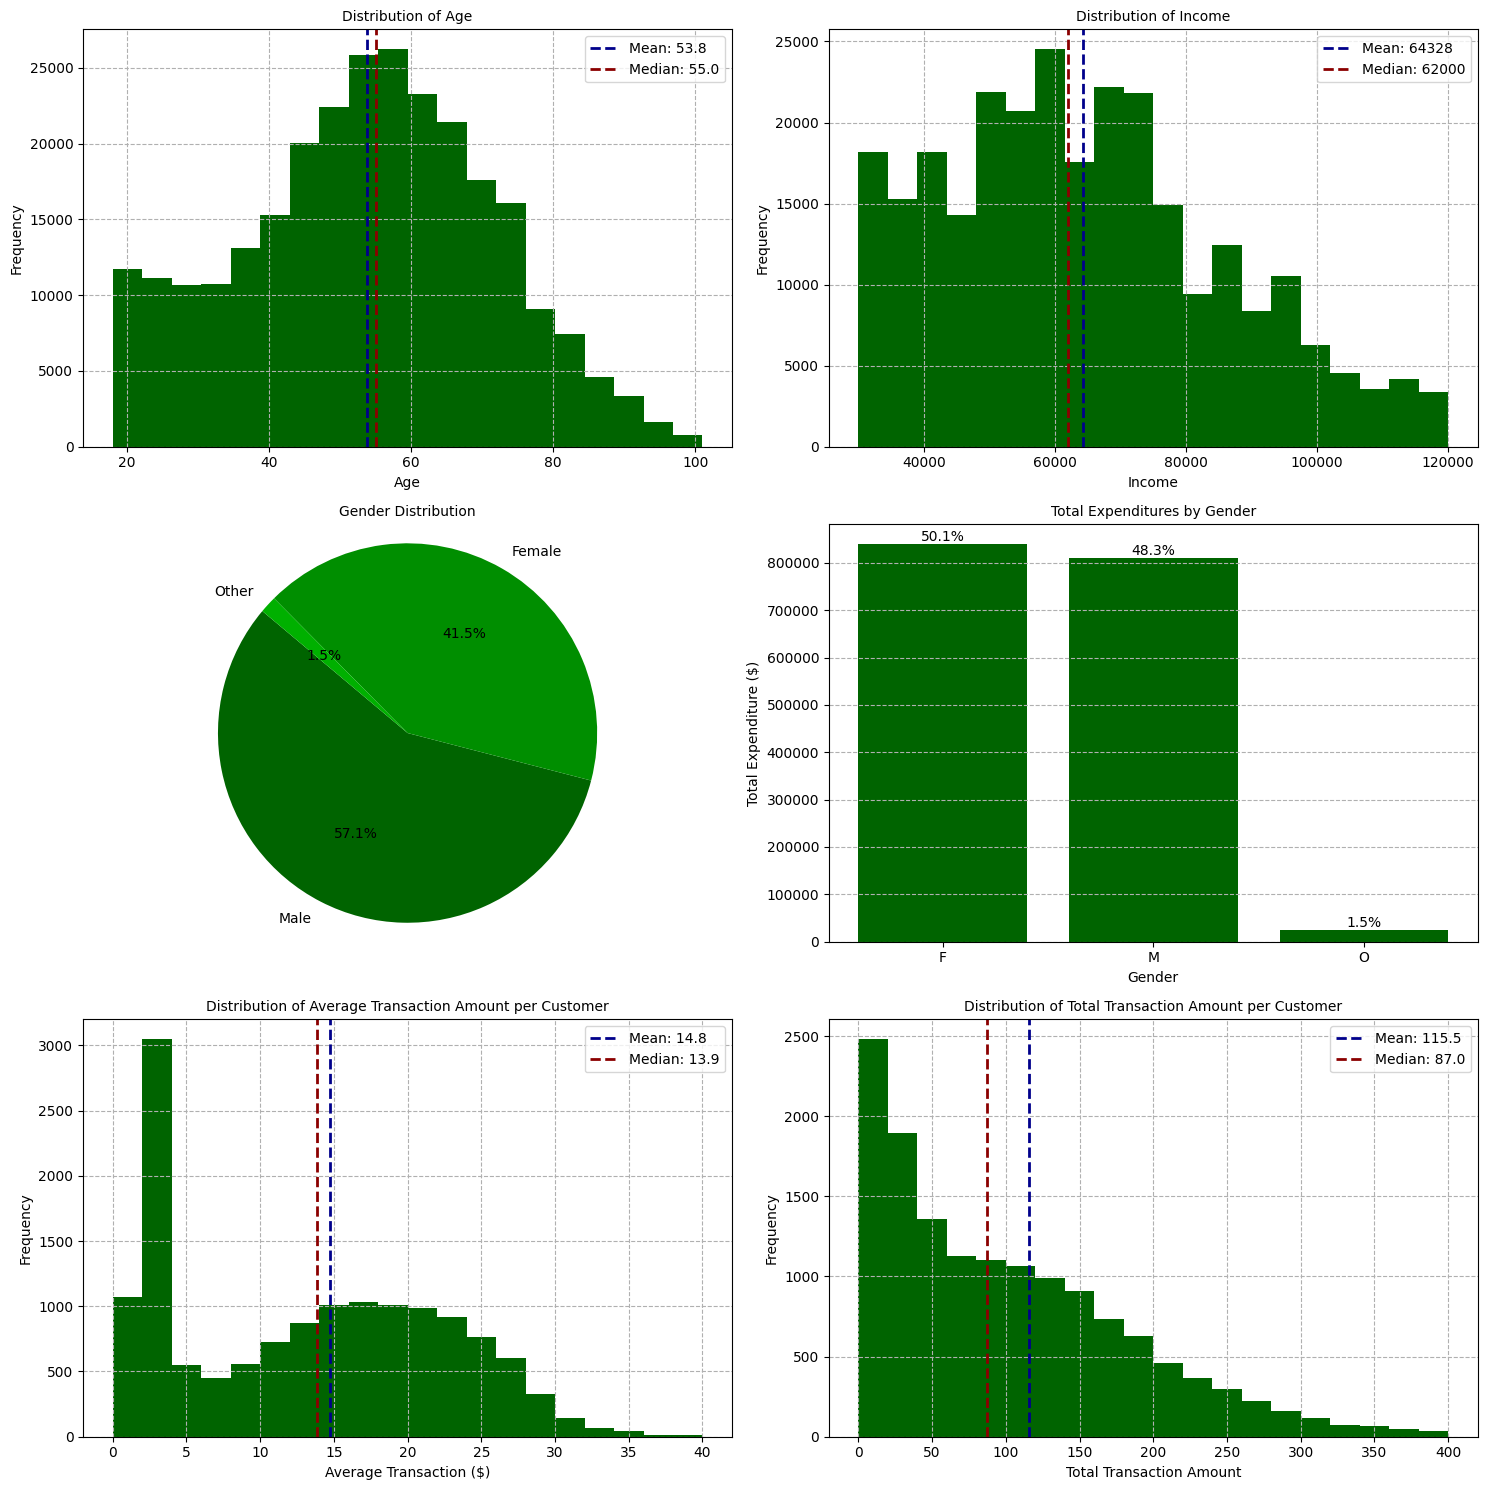

The percentage of customers with an average transaction greater than 40 $ is: 1.94%


In [33]:
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust size as needed

# 1. Distribution of Age
mean_age = df['age'].mean()
median_age = df['age'].median()
axs[0, 0].hist(df['age'], bins=20, color='darkgreen')
axs[0, 0].axvline(mean_age, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.1f}')
axs[0, 0].axvline(median_age, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.1f}')
axs[0, 0].set_title('Distribution of Age', fontsize=10)
axs[0, 0].set_xlabel('Age', fontsize=10)
axs[0, 0].set_ylabel('Frequency', fontsize=10)
axs[0, 0].grid(linestyle='--')
axs[0, 0].legend()

# 2. Distribution of Income
mean_income = df['income'].mean()
median_income = df['income'].median()
axs[0, 1].hist(df['income'], bins=20, color='darkgreen')
axs[0, 1].axvline(mean_income, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_income:.0f}')
axs[0, 1].axvline(median_income, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_income:.0f}')
axs[0, 1].set_title('Distribution of Income', fontsize=10)
axs[0, 1].set_xlabel('Income', fontsize=10)
axs[0, 1].set_ylabel('Frequency', fontsize=10)
axs[0, 1].grid(linestyle='--')
axs[0, 1].legend()

# 3. Gender Pie Chart
gender_counts = df['gender'].value_counts().rename(index={'F': 'Female', 'M': 'Male', 'O': 'Other'})
colors = ['#006400', '#008E00', '#00B000']  # Dark green and lighter greens
axs[1, 0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[1, 0].set_title('Gender Distribution', fontsize=10)
axs[1, 0].axis('equal')  # Ensure the pie chart is round

# 4. Expenditures by Gender
total_expenditures_by_gender = df.groupby('gender')['value_amount'].sum().reset_index()
total_expenditure = total_expenditures_by_gender['value_amount'].sum()
total_expenditures_by_gender['percentage'] = (total_expenditures_by_gender['value_amount'] / total_expenditure) * 100

axs[1, 1].bar(total_expenditures_by_gender['gender'], total_expenditures_by_gender['value_amount'], color='darkgreen')
axs[1, 1].set_title('Total Expenditures by Gender', fontsize=10)
axs[1, 1].set_xlabel('Gender', fontsize=10)
axs[1, 1].set_ylabel('Total Expenditure ($)', fontsize=10)
axs[1, 1].grid(axis='y', linestyle='--')

# Add percentage labels on the bars
for index, row in total_expenditures_by_gender.iterrows():
    axs[1, 1].text(row['gender'], row['value_amount'], f'{row["percentage"]:.1f}%', ha='center', va='bottom')

# 5. Distribution of Average Transaction Amount per Customer
transaction_df = df[df['event'] == 'transaction']
amount = transaction_df.groupby('customer_id')['value_amount'].sum().reset_index()
count = transaction_df.groupby('customer_id')['value_amount'].count().reset_index()
result1 = pd.merge(amount, count, on='customer_id', suffixes=('_total', '_count'))
result1['average_transaction'] = result1['value_amount_total'] / result1['value_amount_count']
mean_result = result1['average_transaction'].mean()
median_result = result1['average_transaction'].median()

axs[2, 0].hist(result1['average_transaction'], bins=20, color='darkgreen', range=(0, 40))
axs[2, 0].axvline(mean_result, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_result:.1f}')
axs[2, 0].axvline(median_result, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_result:.1f}')
axs[2, 0].set_title('Distribution of Average Transaction Amount per Customer', fontsize=10)
axs[2, 0].set_xlabel('Average Transaction ($)', fontsize=10)
axs[2, 0].set_ylabel('Frequency', fontsize=10)
axs[2, 0].grid(linestyle='--')
axs[2, 0].legend()

# 6. Distribution of the transaction amount ('value_amount') per customer ('customer_id')
# Calculate the sum of 'value_amount' for each 'customer_id'
result2 = transaction_df.groupby('customer_id')['value_amount'].sum().reset_index()

# Sort the result in descending order by 'total_value_amount'
result2 = result2.sort_values(by='value_amount', ascending=False)

# Calculate mean and median for the total_value_amount
mean_result = result2['value_amount'].mean()
median_result = result2['value_amount'].median()

# Plotting the histogram
axs[2, 1].hist(result2['value_amount'], bins=20, color='darkgreen', range=(0, 400))

# Adding mean and median lines
axs[2, 1].axvline(mean_result, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_result:.1f}')
axs[2, 1].axvline(median_result, color='darkred', linestyle='dashed', linewidth=2, label=f'Median: {median_result:.1f}')

axs[2, 1].set_title('Distribution of Total Transaction Amount per Customer', fontsize=10)
axs[2, 1].set_xlabel('Total Transaction Amount', fontsize=10)
axs[2, 1].set_ylabel('Frequency', fontsize=10)
axs[2, 1].grid(linestyle='--')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


# Calculate the percentage of customers with average transaction greater than 40
high_value_customers = result1[result1['average_transaction'] > 40]
num_high_value_customers = high_value_customers.shape[0]
total_customers = result1.shape[0]
percentage_high_value_customers = (num_high_value_customers / total_customers) * 100

# Print the result
print(f'The percentage of customers with an average transaction greater than 40 $ is: {percentage_high_value_customers:.2f}%')


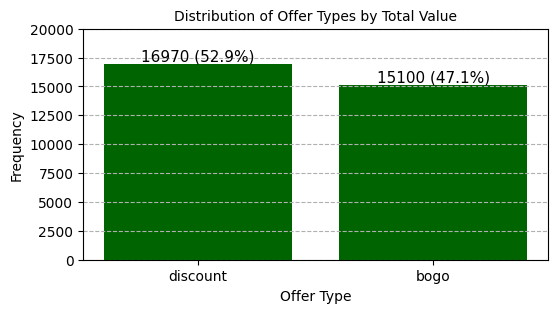

In [34]:
# Count occurrences of each offer type (bogo, discount, informational)  
# => there was no offer_id for informational in df Transcript! 

offer_type_count = df['offer_type'].value_counts()

# Calculate the total number of occurrences
total_count = offer_type_count.sum()

# Bar plot for Distribution of Offer Types
plt.figure(figsize=(6, 3))  
bars = plt.bar(offer_type_count.index, offer_type_count.values, color='darkgreen')
plt.title('Distribution of Offer Types by Total Value', fontsize=10)
plt.xlabel('Offer Type', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.ylim(0, 20000)
plt.grid(axis='y', linestyle='--')

# Annotate bars with percentage values and absolute counts
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.annotate(f'{height} ({percentage:.1f}%)', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 ha='center', va='bottom', fontsize=11)

plt.show()


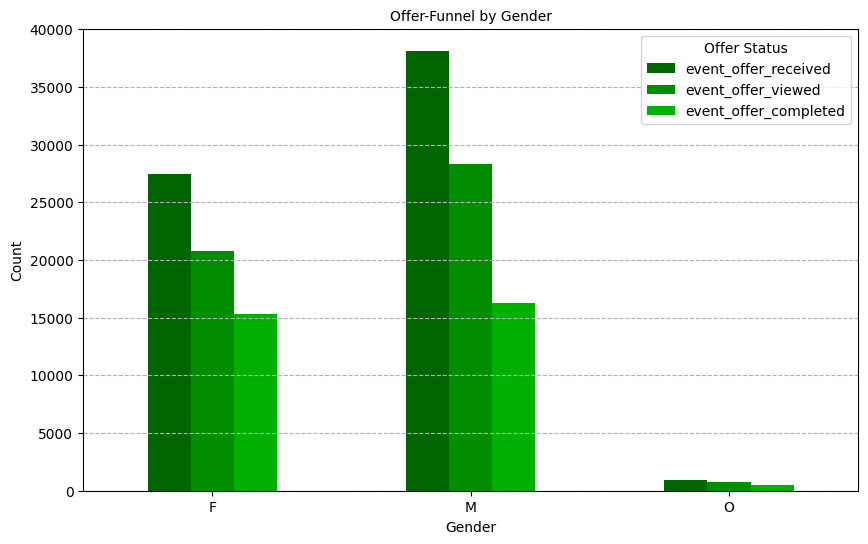

       Absolute Offers                  Percentage of Gender                 
              Received Viewed Completed             Received Viewed Completed
gender                                                                       
F                27456  20786     15316                  41%    42%       48%
M                38129  28301     16259                  57%    57%       51%
O                  916    773       495                   1%     2%        2%
Total            66501  49860     32070                 100%   100%      100%


In [35]:
# Group by 'gender' and calculate the sum of offer status columns
grouped_gender = df.groupby('gender')[['event_offer_received', 'event_offer_viewed', 'event_offer_completed']].sum()


# Define colors: dark green and two lighter greens
colors = ['#006400', '#008E00', '#00B000']  # Dark green, lighter green 1, lighter green 2

# Plot histograms for offer status distribution grouped by gender with custom colors
grouped_gender.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Offer-Funnel by Gender', fontsize=10)
plt.xlabel('Gender', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=0)
plt.legend(title='Offer Status')
plt.grid(axis='y', linestyle='--')
plt.show()


# Group by 'gender' and calculate the sum of offer status columns
grouped_gender = df.groupby('gender')[['event_offer_received', 'event_offer_viewed', 'event_offer_completed']].sum()

# Calculate the total counts for each offer status (not gender)
total_counts = grouped_gender.sum(axis=0)

# Calculate percentage values based on total counts for each offer status
percentage_values = grouped_gender.div(total_counts, axis=1) * 100

# Create a new DataFrame to combine absolute and percentage values
combined_table = pd.concat([grouped_gender, percentage_values], axis=1, keys=['Absolute Offers', 'Percentage of Gender'])

# Rename the columns to match the number of columns in combined_table
combined_table.columns = pd.MultiIndex.from_tuples([
    ('Absolute Offers', 'Received'),
    ('Absolute Offers', 'Viewed'),
    ('Absolute Offers', 'Completed'),
    ('Percentage of Gender', 'Received'),
    ('Percentage of Gender', 'Viewed'),
    ('Percentage of Gender', 'Completed')
])

# Add a row for the sum of each column
combined_table.loc['Total'] = combined_table.sum()

# Format absolute values as integers (no decimal places)
combined_table['Absolute Offers'] = combined_table['Absolute Offers'].astype(int)

# Format percentage values as whole numbers with a '%' sign
combined_table['Percentage of Gender'] = combined_table['Percentage of Gender'].round(0).astype(int).astype(str) + '%'

# Display the combined table
print(combined_table)


In [36]:
# Group by 'gender' and calculate the sum of offer status columns
grouped_gender = df.groupby('gender')[['event_offer_received', 'event_offer_completed']].sum()

# Calculate the percentage of completed offers out of received offers
grouped_gender['percentage_completed'] = (grouped_gender['event_offer_completed'] / grouped_gender['event_offer_received']) * 100

# Add a row for the total counts
grouped_gender.loc['Total'] = grouped_gender.sum()

# Calculate the percentage for the Total row correctly
total_received = grouped_gender.loc['Total', 'event_offer_received']
total_completed = grouped_gender.loc['Total', 'event_offer_completed']
grouped_gender.loc['Total', 'percentage_completed'] = (total_completed / total_received) * 100

# Format the percentage values to whole numbers and add a '%' sign
grouped_gender['percentage_completed'] = grouped_gender['percentage_completed'].round(0).astype(int).astype(str) + '%'

# Rename the columns
grouped_gender.rename(columns={
    'event_offer_received': 'Received',
    'event_offer_completed': 'Completed',
    'percentage_completed': 'Percentage Completed'
}, inplace=True)

# Display the updated table
print(grouped_gender)


        Received  Completed Percentage Completed
gender                                          
F        27456.0    15316.0                  56%
M        38129.0    16259.0                  43%
O          916.0      495.0                  54%
Total    66501.0    32070.0                  48%


In [37]:
# Save dataframe df as csv-File
df.to_csv('df.csv', index=False)


## 5. Machine Learning Models
### a) Data Preaparation and Correlation Matrix

In [38]:
# Load the CSV file into a new DataFrame named df_ml
df_ml = pd.read_csv('df.csv')

# Replace NaN values with 0 in the columns 'offer_id', 'channels', and 'offer_type'
# Here, 0 indicates the absence of a value
df_ml[['offer_id', 'channels', 'offer_type']] = df_ml[['offer_id', 'channels', 'offer_type']].fillna(0)

# Drop columns that have been split into categorical columns previously
df_ml = df_ml.drop(columns=['event', 'gender', 'became_member_on', 'channels', 'offer_type'])

# Create a new column 'offer_id_long' to retain the original 'offer_id' values
df_ml['offer_id_long'] = df_ml['offer_id']

# Convert 'offer_id' to a categorical index starting from 1
df_ml['offer_id'] = pd.factorize(df_ml['offer_id'])[0] + 1

# Create a new column 'customer_id_long' to retain the original 'customer_id' values
df_ml['customer_id_long'] = df_ml['customer_id']

# Convert 'customer_id' to a categorical index starting from 1
df_ml['customer_id'] = pd.factorize(df_ml['customer_id'])[0] + 1


In [39]:
# Check the conversion of the offer_id into numeric value

# Retrieve unique values from the 'offer_id' column
unique_offer_id = df_ml['offer_id'].unique()

# Retrieve unique values from the 'offer_id_long' column
unique_offer_id_long = df_ml['offer_id_long'].unique()

# Create a DataFrame to display the unique values
table_offer_id = pd.DataFrame({
    'Offer ID': unique_offer_id,
    'Offer ID Long': unique_offer_id_long
})

# Display the first 20 unique values
table_offer_id.head(20)


,Offer ID,Offer ID Long
0,1,0
1,2,2906b810c7d4411798c6938adc9daaa5
2,3,fafdcd668e3743c1bb461111dcafc2a4
3,4,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,ae264e3637204a6fb9bb56bc8210ddfd
5,6,4d5c57ea9a6940dd891ad53e9dbe8da0
6,7,2298d6c36e964ae4a3e7e9706d1fb8c2
7,8,f19421c1d4aa40978ebb69ca19b0e20d
8,9,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [40]:
# Check the conversion of the customer_id into numeric value

# Retrieve unique values from the 'customer_id' column
unique_customer_id = df_ml['customer_id'].unique()

# Retrieve unique values from the 'customer_id_long' column
unique_customer_id_long = df_ml['customer_id_long'].unique()

# Create a DataFrame to display the unique values
table_customer_id = pd.DataFrame({
    'Customer ID': unique_customer_id,
    'Customer ID Long': unique_customer_id_long
})

# Display the unique values
table_customer_id.head(10)


,Customer ID,Customer ID Long
0,1,78afa995795e4d85b5d9ceeca43f5fef
1,2,e2127556f4f64592b11af22de27a7932
2,3,389bc3fa690240e798340f5a15918d5c
3,4,2eeac8d8feae4a8cad5a6af0499a211d
4,5,aa4862eba776480b8bb9c68455b8c2e1
5,6,31dda685af34476cad5bc968bdb01c53
6,7,4b0da7e80e5945209a1fdddfe813dbe0
7,8,c27e0d6ab72c455a8bb66d980963de60
8,9,d53717f5400c4e84affdaeda9dd926b3
9,10,f806632c011441378d4646567f357a21


In [41]:
# Delete the columns 'offer_id_long' and 'offer_id_long' from dataframe df_ml
df_ml = df_ml.drop(columns=['offer_id_long', 'customer_id_long'])
df_ml.head()


,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,value_amount,value_rewards,reward,difficulty,duration,customer_id,gender_F,gender_M,gender_O,age,age_genz,age_geny,age_genx,age_babybo,age_silgen,income,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high,member_since_year,membership_duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount
0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,75,0,0,0,0,1,100000,0,0,0,0,1,2017,2880,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,2,0,1,0,68,0,0,0,1,0,70000,0,0,1,0,0,2018,2528,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,3,0,1,0,65,0,0,0,1,0,53000,0,1,0,0,0,2018,2604,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,4,0,1,0,58,0,0,0,1,0,51000,0,1,0,0,0,2017,2694,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,5,1,0,0,61,0,0,0,1,0,57000,0,1,0,0,0,2017,2755,0,0,0,0,0,0


In [42]:
# Last check of df_ml

nan_counts = df_ml.isna().sum()  # Count NaN values for each column
total_counts = len(df_ml)  # Total number of rows in the DataFrame

# Calculate the proportion of NaN values
nan_proportions = (nan_counts / total_counts) * 100  # Convert to percentage

# Create a DataFrame to display the results
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'NaN Proportion (%)': nan_proportions
})

# Display the summary
print(nan_summary)


                       NaN Count  NaN Proportion (%)
offer_id                       0                 0.0
event_offer_completed          0                 0.0
event_offer_received           0                 0.0
event_offer_viewed             0                 0.0
event_transaction              0                 0.0
time                           0                 0.0
value_amount                   0                 0.0
value_rewards                  0                 0.0
reward                         0                 0.0
difficulty                     0                 0.0
duration                       0                 0.0
customer_id                    0                 0.0
gender_F                       0                 0.0
gender_M                       0                 0.0
gender_O                       0                 0.0
age                            0                 0.0
age_genz                       0                 0.0
age_geny                       0              

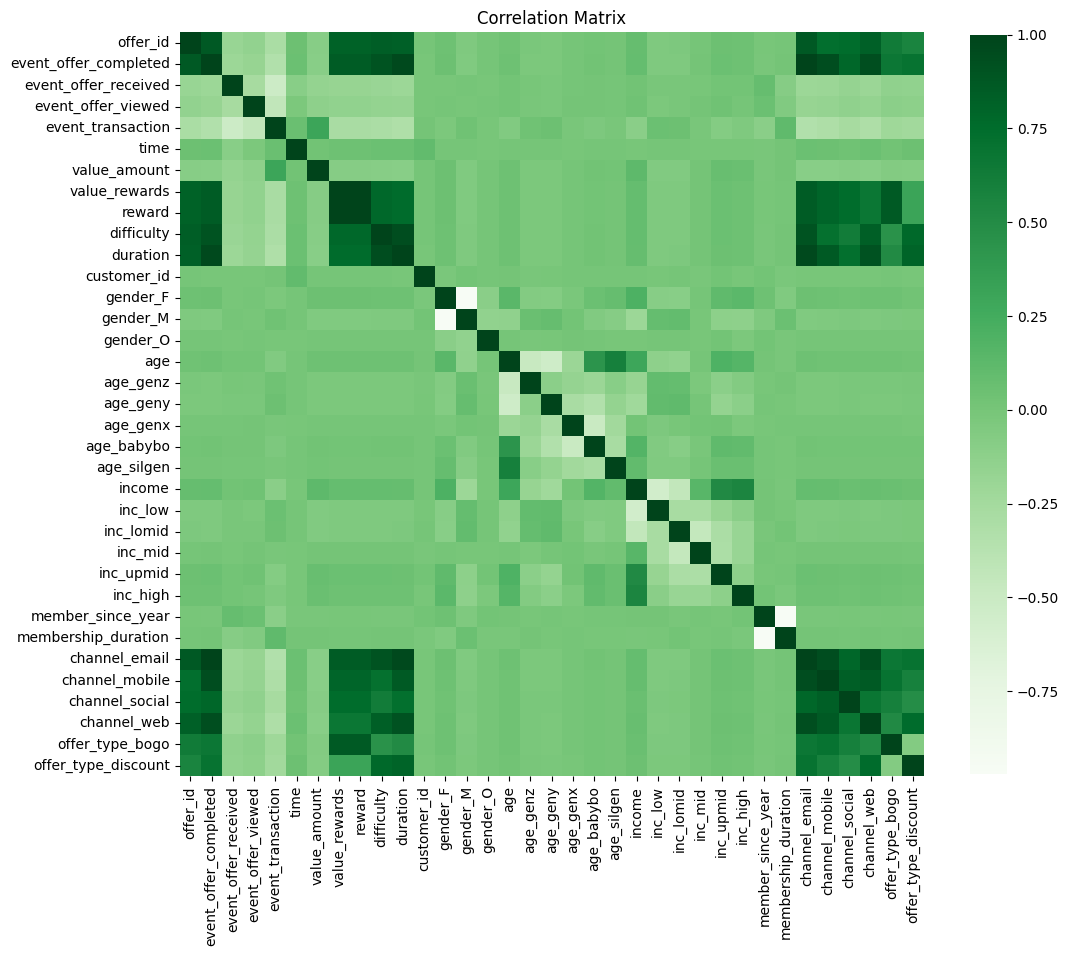

In [43]:
correlation_matrix = df_ml.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='Greens', fmt=".1f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', bbox_inches='tight', dpi=300)
plt.show()


In [44]:
# Better readable alternative: Calculate the correlation matrix
correlation_matrix = df_ml.corr()

# Apply the background gradient
styled_correlation = correlation_matrix.style.background_gradient(cmap='Greens')

# Display the styled correlation matrix
styled_correlation


,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,value_amount,value_rewards,reward,difficulty,duration,customer_id,gender_F,gender_M,gender_O,age,age_genz,age_geny,age_genx,age_babybo,age_silgen,income,inc_low,inc_lomid,inc_mid,inc_upmid,inc_high,member_since_year,membership_duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount
offer_id,1.000000,0.876069,-0.181884,-0.151488,-0.292461,0.050901,-0.087605,0.817796,0.817796,0.838727,0.824942,-0.000696,0.042936,-0.043546,0.003345,0.037305,-0.022593,-0.028032,0.003758,0.020395,0.013192,0.079449,-0.041656,-0.036075,0.006166,0.050705,0.038071,-0.006265,0.005665,0.876069,0.736147,0.748779,0.829912,0.633939,0.568015
event_offer_completed,0.876069,1.000000,-0.207614,-0.172918,-0.333833,0.057841,-0.099997,0.847840,0.847840,0.901476,0.968334,-0.001368,0.046678,-0.047110,0.002680,0.041484,-0.026365,-0.030574,0.003670,0.024336,0.013174,0.087484,-0.046459,-0.040918,0.009473,0.054359,0.042146,-0.009292,0.008362,1.000000,0.940607,0.786343,0.935150,0.663166,0.705600
event_offer_received,-0.181884,-0.207614,1.000000,-0.269019,-0.519365,-0.096114,-0.155572,-0.176023,-0.176023,-0.187159,-0.201039,-0.005259,-0.002034,0.002923,-0.003712,0.017184,-0.007781,-0.016449,0.001036,0.012634,0.004301,0.027919,-0.009760,-0.013089,-0.003855,0.017658,0.018915,0.076787,-0.078736,-0.207614,-0.195283,-0.163255,-0.194150,-0.137682,-0.146492
event_offer_viewed,-0.151488,-0.172918,-0.269019,1.000000,-0.432571,-0.028232,-0.129573,-0.146607,-0.146607,-0.155881,-0.167442,-0.005483,0.002170,-0.003065,0.003743,0.021740,-0.015561,-0.023165,0.010990,0.011893,0.004862,0.033726,-0.023837,-0.014500,0.007350,0.030371,0.001066,0.060216,-0.061616,-0.172918,-0.162648,-0.135973,-0.161704,-0.114673,-0.122011
event_transaction,-0.292461,-0.333833,-0.519365,-0.432571,1.000000,0.067401,0.299543,-0.283037,-0.283037,-0.300943,-0.323262,0.009679,-0.030141,0.030349,-0.001439,-0.058555,0.035860,0.051966,-0.011804,-0.035885,-0.016012,-0.106895,0.056999,0.049033,-0.008513,-0.073999,-0.044422,-0.106986,0.110357,-0.333833,-0.314006,-0.262507,-0.312184,-0.221387,-0.235553
time,0.050901,0.057841,-0.096114,-0.028232,0.067401,1.000000,0.023737,0.045313,0.045313,0.059297,0.059874,0.102584,-0.000466,0.001616,-0.004761,0.002039,-0.000693,0.000342,-0.002191,-0.000647,0.004169,-0.003715,0.003710,-0.000184,-0.001039,-0.000826,-0.001629,-0.008511,0.007216,0.057841,0.048337,0.034489,0.055256,0.028900,0.049767
value_amount,-0.087605,-0.099997,-0.155572,-0.129573,0.299543,0.023737,1.000000,-0.084782,-0.084782,-0.090145,-0.096831,0.004678,0.048202,-0.048354,0.001555,0.042629,-0.024058,-0.030538,0.000917,0.024119,0.015599,0.116433,-0.056160,-0.057892,0.008018,0.073942,0.060868,-0.011758,0.011073,-0.099997,-0.094058,-0.078632,-0.093512,-0.066315,-0.070558
value_rewards,0.817796,0.847840,-0.176023,-0.146607,-0.283037,0.045313,-0.084782,1.000000,1.000000,0.780681,0.759331,-0.000183,0.048173,-0.048639,0.002851,0.040294,-0.025946,-0.031106,0.006231,0.022144,0.013122,0.087795,-0.046669,-0.040724,0.009124,0.055295,0.041330,-0.003522,0.002533,0.847840,0.796358,0.747435,0.676613,0.862899,0.313608
reward,0.817796,0.847840,-0.176023,-0.146607,-0.283037,0.045313,-0.084782,1.000000,1.000000,0.780681,0.759331,-0.000183,0.048173,-0.048639,0.002851,0.040294,-0.025946,-0.031106,0.006231,0.022144,0.013122,0.087795,-0.046669,-0.040724,0.009124,0.055295,0.041330,-0.003522,0.002533,0.847840,0.796358,0.747435,0.676613,0.862899,0.313608
difficulty,0.838727,0.901476,-0.187159,-0.155881,-0.300943,0.059297,-0.090145,0.780681,0.780681,1.000000,0.939631,-0.000527,0.045311,-0.045879,0.003219,0.040726,-0.025792,-0.030513,0.003615,0.024368,0.012706,0.086834,-0.046657,-0.039822,0.008468,0.054928,0.041404,-0.008660,0.007747,0.901476,0.720758,0.624340,0.833864,0.450825,0.775256


In [45]:
df_ml.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   offer_id               272388 non-null  int64
 1   event_offer_completed  272388 non-null  int64
 2   event_offer_received   272388 non-null  int64
 3   event_offer_viewed     272388 non-null  int64
 4   event_transaction      272388 non-null  int64
 5   time                   272388 non-null  int64
 6   value_amount           272388 non-null  int64
 7   value_rewards          272388 non-null  int64
 8   reward                 272388 non-null  int64
 9   difficulty             272388 non-null  int64
 10  duration               272388 non-null  int64
 11  customer_id            272388 non-null  int64
 12  gender_F               272388 non-null  int64
 13  gender_M               272388 non-null  int64
 14  gender_O               272388 non-null  int64
 15  age              

In [46]:
# To reduce class imbalance the three gender-columns are vonverted back to one gender column.
# Create the 'gender' column based on the conditions specified
df_ml.loc[:, 'gender'] = 0  # Initialize the 'gender' column with default value 0

# Update 'gender' column based on conditions
df_ml.loc[df_ml['gender_M'] == 1, 'gender'] = 1  # Set to 1 where gender_M is 1
df_ml.loc[df_ml['gender_F'] == 1, 'gender'] = 2  # Set to 2 where gender_F is 1


# Prepare df_prep dataframe for Decision Tree Classifier
df_prep = df_ml[['time','event_offer_completed', 'value_amount', 'gender', 'age', 'income', 'member_since_year']]

# 1) Split the Model
X = df_prep[['time', 'value_amount','gender', 'age', 'income', 'member_since_year']]
y = df_prep['event_offer_completed']


# 2) Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)


###  b) Decision Tree Classifier


In [47]:
# Definition of dataset for Decision Tree Classifier

# Decision Tree Classifier

# Initialize the Decision Tree Classifier with a fixed random state for reproducibility
clf = DecisionTreeClassifier(random_state=55)

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# 4) Calculate and display the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")

# Handle class imbalance by resampling the data (upsampling the minority class)
# Extract the minority class from the training set
X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]

# Upsample the minority class to match the size of the majority class
X_train_resampled, y_train_resampled = resample(X_train_minority, y_train_minority,
                                               replace=True, 
                                               n_samples=X_train[y_train == 0].shape[0],
                                               random_state=55)

# Combine the majority class with the resampled minority class to create a balanced training set
X_train_balanced = pd.concat([X_train[y_train == 0], X_train_resampled])
y_train_balanced = pd.concat([y_train[y_train == 0], y_train_resampled])

# Retrain the classifier using the balanced training data
clf_balanced = DecisionTreeClassifier(random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set with the balanced classifier
y_pred_balanced = clf_balanced.predict(X_test)

# Calculate and display the accuracy of the balanced model
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Accuracy of the balanced model: {accuracy_balanced:.2f}")

# Display the classification report for the balanced model
print("\nClassification Report for Decision Tree Classifier (balanced model):")
print(classification_report(y_test, y_pred_balanced))


Accuracy of the model: 0.86
Accuracy of the balanced model: 0.85

Classification Report for Decision Tree Classifier (balanced model):
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     71976
           1       0.38      0.41      0.39      9741

    accuracy                           0.85     81717
   macro avg       0.65      0.66      0.65     81717
weighted avg       0.86      0.85      0.85     81717



###  c) Decision Tree Classifier with defined hyperparameters grid for Grid Search

In [48]:
# Decision Tree Classifier with defined hyperparameters grid for Grid Search

# Initialize the Decision Tree Classifier
clf1 = DecisionTreeClassifier(random_state=55)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search1 = GridSearchCV(clf1, param_grid, cv=5)

# Perform grid search on your training data
grid_search1.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search1.best_params_)

# Get the best estimator/model
best_clf1 = grid_search1.best_estimator_

# Fit the best model on your training data
best_clf1.fit(X_train, y_train)

# Predict using the best model
y_pred = best_clf1.predict(X_test)

# Print classification report
print("\nClassification Report for Decision Tree Classifier with defined hyperparameters for Grid Search:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

Classification Report for Decision Tree Classifier with defined hyperparameters for Grid Search:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     71976
           1       0.55      0.23      0.33      9741

    accuracy                           0.89     81717
   macro avg       0.73      0.60      0.63     81717
weighted avg       0.86      0.89      0.86     81717



###  d) Decision Tree Classifier with Randomized Search of Hyperparameters

In [49]:
# Decision Tree Classifier with randomized search of hyperparameters with RandomizedSearchCV

# Initialize the Decision Tree Classifier
clf2 = DecisionTreeClassifier(random_state=55)

# Define the hyperparameter distribution for Randomized Search
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)  
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf2, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# Perform random search on your training data
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Get the best estimator/model
best_clf2 = random_search.best_estimator_

# Fit the best model on your training data
best_clf2.fit(X_train, y_train)

# Predict using the best model
y_pred = best_clf2.predict(X_test)

# Print classification report
print("\nClassification Report for Decision Tree Classifier with Randomized Search of Hyperparameters:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}

Classification Report for Decision Tree Classifier with Randomized Search of Hyperparameters:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     71976
           1       0.55      0.23      0.33      9741

    accuracy                           0.89     81717
   macro avg       0.73      0.60      0.63     81717
weighted avg       0.86      0.89      0.86     81717



In [50]:
# Cross Validation on Decision Tree Classifier with Randomized Search of Hyperparameters
# Initialize the Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7)

# Perform Cross Validation and print the scores
cv_scores = cross_val_score(clf2, X, y, cv=5, scoring='accuracy')
print("Cross Validation on Decision Tree Classifier with Randomized Search of Hyperparameters:")
print("Cross Validation scores:", cv_scores)
print("Average accuracy:", cv_scores.mean())


Cross Validation on Decision Tree Classifier with Randomized Search of Hyperparameters:
Cross Validation scores: [0.8824296  0.79334777 0.5477624  0.56935955 0.59568258]
Average accuracy: 0.6777163810790701


###  e) Gradient Boosting Classifier

In [51]:
# Gradient Boosting Classifier

# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report for Gradient Boosting Classifier:")
print(class_report)


Accuracy Score: 0.8852
Classification Report for Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     71976
           1       0.60      0.11      0.18      9741

    accuracy                           0.89     81717
   macro avg       0.75      0.55      0.56     81717
weighted avg       0.86      0.89      0.85     81717



###  f) Gradient Boosting Classifier with defined hyperparameters grid for Grid Search

In [52]:
# Create the Gradient Boosting Classifier 
clf3 = GradientBoostingClassifier(random_state=55)

# Define hyperparameters for tuning
param_distributions = {
    'n_estimators': [50, 100, 150],  # Adjusts the number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.2],  # Adjusts the learning rate
    'max_depth': [3, 4, 5]  # Adjusts the maximum depth of the trees
}

# Perform Randomized Search to find the best parameters
random_search = RandomizedSearchCV(estimator=clf3, param_distributions=param_distributions, 
                                   n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Predict on the test set
y_pred = random_search.predict(X_test)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report for Gradient Boosting Classifier with defined hyperparameters grid for Randomized Search:")
print(classification_rep)


Best Parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Classification Report for Gradient Boosting Classifier with defined hyperparameters grid for Randomized Search:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     71976
           1       0.59      0.29      0.39      9741

    accuracy                           0.89     81717
   macro avg       0.75      0.63      0.66     81717
weighted avg       0.87      0.89      0.87     81717



In [53]:
# Cross validation on Gradient Boosting Classifier with defined hyperparameters grid for Grid Search
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)

# Perform cross-validation with 5 folds
gbc_scores = cross_val_score(gbc, X, y, cv=5)

# Print the cross-validation scores
print("Cross Validation on Gradient Boosting Classifier with defined hyperparameters grid for Grid Search")
print("Cross Validation Scores:", gbc_scores)
print("Mean Cross Validation Scores:", gbc_scores.mean())


Cross Validation on Gradient Boosting Classifier with defined hyperparameters grid for Grid Search
Cross Validation Scores: [0.8822644  0.79334777 0.5477624  0.56774419 0.59522367]
Mean Cross Validation Scores: 0.677268486243467


### h) VotingClassifier: Ensemble Gradient Boosting Classifier, Random Forest Classifier and Decision Tree Classifier


In [54]:
### VotingClassifier: Ensemble Gradient Boosting Classifier, Random Forest Classifier and Decision Tree Classifier

# Initialize models with ideal parameters
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)

# Create the VotingClassifier with Gradient Boosting, Decision Tree, and Random Forest
voting_classifier = VotingClassifier(
    estimators=[
        ('gboost', gboost),
        ('dt', decision_tree),
        ('rf', random_forest)
    ],
    voting='hard'  # Use hard voting for classification
)

# Perform cross-validation
cv_scores = cross_val_score(voting_classifier, X, y, cv=5, scoring='accuracy')

# Fit the VotingClassifier on the training data
voting_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_classifier.predict(X_test)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Print the classification report
print("\nClassification Report: VotingClassifier: Ensemble Gradient Boosting , Random Forest and Decision Tree Classifier")
print(classification_report(y_test, y_pred))


Cross-validation scores: [0.8822644  0.79334777 0.5477624  0.56930448 0.59571929]
Mean CV Accuracy: 0.6776796689444234

Classification Report: VotingClassifier: Ensemble Gradient Boosting , Random Forest and Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     71976
           1       0.59      0.17      0.27      9741

    accuracy                           0.89     81717
   macro avg       0.74      0.58      0.60     81717
weighted avg       0.86      0.89      0.86     81717



In [56]:
# Conclusion: The best model is:
# Decision Tree Classifier with Randomized Search of Hyperparameters
# Best Parameters: 
# - 'max_depth': 10
# - 'min_samples_leaf': 2
# - 'min_samples_split': 7

# Define the Decision Tree Classifier with the best parameters
best_classifier = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7)

# Fit the model to the data
best_classifier.fit(X, y)

# Obtain feature importances
feature_importances = best_classifier.feature_importances_

# Match feature importances with feature names
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)

# Make predictions on the test dataset (if you have a separate test set)
y_pred = best_classifier.predict(X_test)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report for Decision Tree Classifier with Randomized Search of Hyperparameters:")
print("Parameters: 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7\n")
print(classification_rep)


Feature Importance Scores:
             Feature  Importance
0               time    0.551580
1       value_amount    0.368817
4             income    0.047144
5  member_since_year    0.012851
3                age    0.011771
2             gender    0.007837

Classification Report for Decision Tree Classifier with Randomized Search of Hyperparameters:
Parameters: 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     71976
           1       0.60      0.21      0.31      9741

    accuracy                           0.89     81717
   macro avg       0.75      0.59      0.62     81717
weighted avg       0.87      0.89      0.86     81717

